#1. 데이터 불러오기

In [31]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall


import warnings
warnings.filterwarnings("ignore")

In [33]:
train = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/train/train")
test = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/test/test")
val = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/val/val")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


#2. 전처리
데이터 확인, 정규화, 시각화

In [34]:
print(train.class_names)

['NORMAL', 'PNEUMONIA']


In [35]:
batch = train.as_numpy_iterator().next()

In [36]:
print(batch)

(array([[[[9.62988281e+00, 9.62988281e+00, 9.62988281e+00],
         [2.33789062e+00, 2.33789062e+00, 2.33789062e+00],
         [3.98437500e+01, 3.98437500e+01, 3.98437500e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.14648438e+00, 3.14648438e+00, 3.14648438e+00],
         [8.93554688e-01, 8.93554688e-01, 8.93554688e-01],
         [4.68750000e-01, 4.68750000e-01, 4.68750000e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.36767578e+01, 5.36767578e+01, 5.36767578e+01],
         [1.46484375e-01, 1.46484375e-01, 1.46484375e-01],
         [4.61425781e+00, 4.61425781e+00, 4.61425781e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         

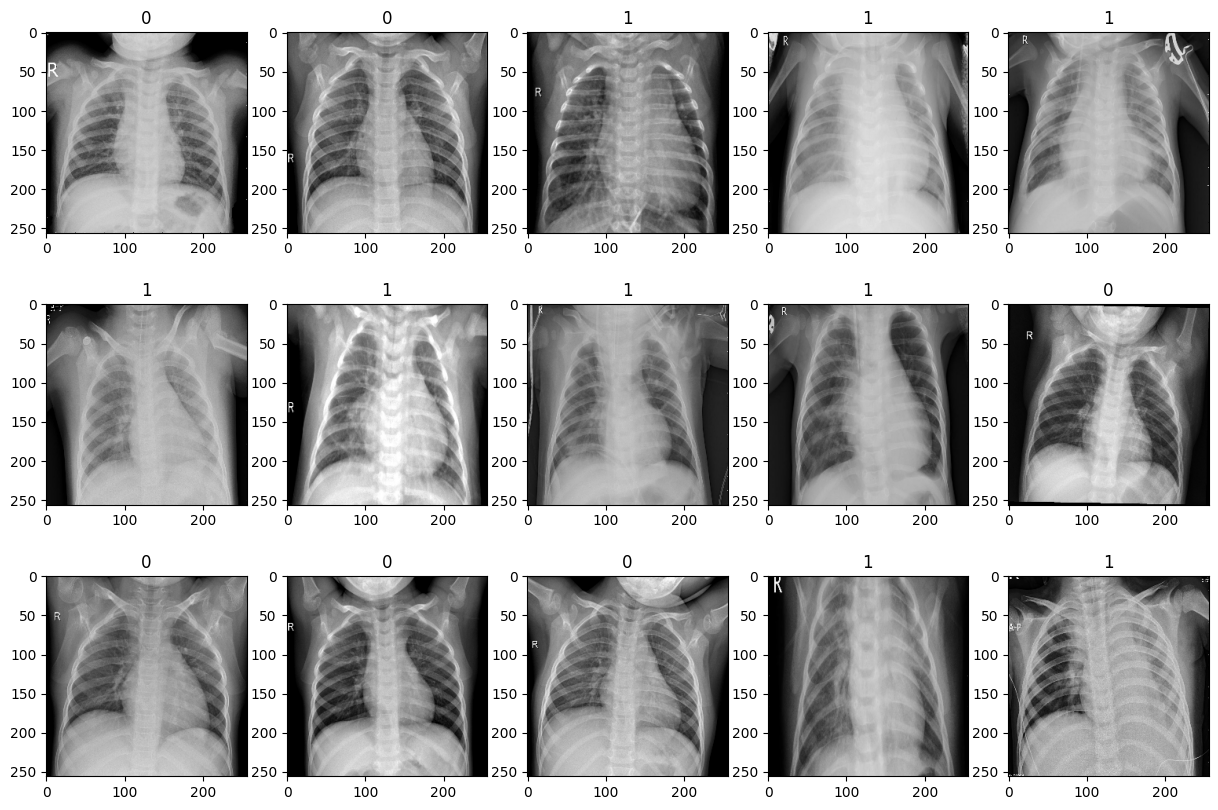

In [37]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [38]:
#정규화
train = train.map(lambda x, y:(x/255, y))
test = test.map(lambda x, y:(x/255, y))
val = val.map(lambda x, y:(x/255, y))

In [55]:
#학습 데이터의 증강
AUTOTUNE = tf.data.AUTOTUNE #CPU/GPU 상황을 보고 적절한 병렬성/버퍼링 크기를 자동 결정.

# 1) 학습 전용 증강 파이프라인 (가벼운 변형)
augment = keras.Sequential([
    layers.RandomFlip('horizontal'),  # 이미지를 좌우로 무작위 뒤집기
    layers.RandomRotation(0.05),  # 약 ±5% 회전
    layers.RandomZoom(0.1), # 최대 10% 확대/축소
    layers.RandomContrast(0.1) # 밝기/대비 10% 변화
], name="data_augmentation")

# 2) 학습셋에만 증강 적용 (정규화 x/255 이후에 적용하는 현재 구조 유지)
train = train.map(lambda x, y: (augment(x, training=True), y),
                  num_parallel_calls=AUTOTUNE)

# 3) 성능 최적화 공통 설정
train = train.prefetch(AUTOTUNE)
val   = val.prefetch(AUTOTUNE)
test  = test.prefetch(AUTOTUNE)

In [56]:
batch = train.as_numpy_iterator().next()

In [58]:
print(batch)

(array([[[[0.2575938 , 0.2575938 , 0.2575938 ],
         [0.2554217 , 0.2554217 , 0.2554217 ],
         [0.23262344, 0.23262344, 0.23262344],
         ...,
         [0.24054836, 0.24054836, 0.24054836],
         [0.24247265, 0.24247265, 0.24247265],
         [0.24747525, 0.24747525, 0.24747525]],

        [[0.26483518, 0.26483518, 0.26483518],
         [0.25225157, 0.25225157, 0.25225157],
         [0.22287227, 0.22287227, 0.22287227],
         ...,
         [0.2462742 , 0.2462742 , 0.2462742 ],
         [0.24621359, 0.24621359, 0.24621359],
         [0.23938192, 0.23938192, 0.23938192]],

        [[0.25384492, 0.25384492, 0.25384492],
         [0.24203369, 0.24203369, 0.24203369],
         [0.21922167, 0.21922167, 0.21922167],
         ...,
         [0.2548898 , 0.2548898 , 0.2548898 ],
         [0.24990782, 0.24990782, 0.24990782],
         [0.23803842, 0.23803842, 0.23803842]],

        ...,

        [[0.548404  , 0.548404  , 0.548404  ],
         [0.5458595 , 0.5458595 , 0.5458595 

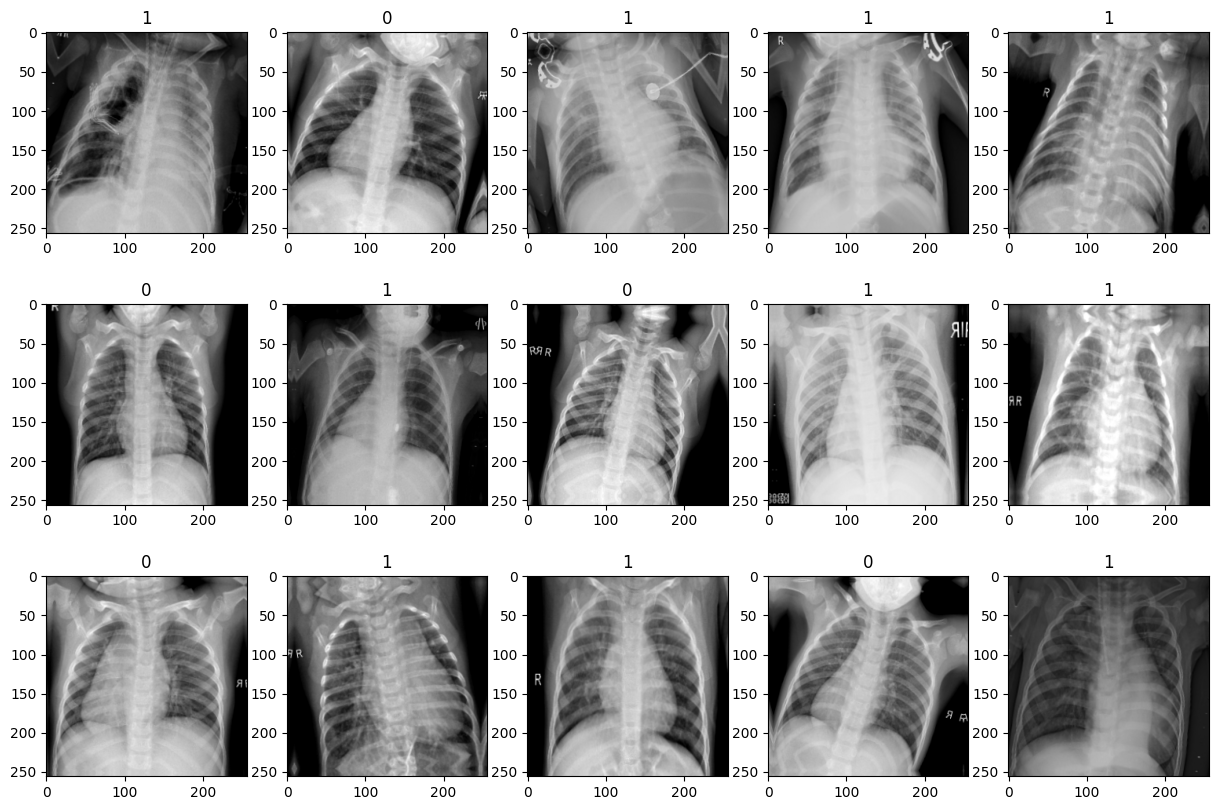

In [59]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#3. 모델생성_1
이진 헤드만 학습 (백본 동결, learning rate=0.001)

In [60]:
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
# 사전학습 백본 (top 제거, 동결)
base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
base.trainable = False

In [62]:
#이진 분류 헤드 추가
finetune_model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Lambda(lambda z: resnet50.preprocess_input(z * 255.0)),  # 현재 train/val/test가 x/255로 0~1이므로, 255를 곱해 원래 스케일로 되돌린 뒤 preprocess_input
    base,
    layers.GlobalAveragePooling2D(),      # Flatten 대신 권장
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
finetune_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,913 (90.48 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [63]:
#모델 컴파일
finetune_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [64]:
#모델 학습
history1 = finetune_model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 668ms/step - accuracy: 0.8436 - loss: 0.4073 - val_accuracy: 0.6250 - val_loss: 0.8452
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 645ms/step - accuracy: 0.9351 - loss: 0.1645 - val_accuracy: 0.8125 - val_loss: 0.3983
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 686ms/step - accuracy: 0.9518 - loss: 0.1329 - val_accuracy: 0.6250 - val_loss: 0.5496
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.9587 - loss: 0.1125 - val_accuracy: 0.6250 - val_loss: 0.4572
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 632ms/step - accuracy: 0.9581 - loss: 0.1051 - val_accuracy: 0.8750 - val_loss: 0.3148
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.9657 - loss: 0.0950 - val_accuracy: 0.8125 - val_loss: 0.2681
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 633ms/step - accuracy: 0.9679 - loss: 0.0927 - val_accuracy: 0.7500 - val_loss: 0.3459
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.9692 -

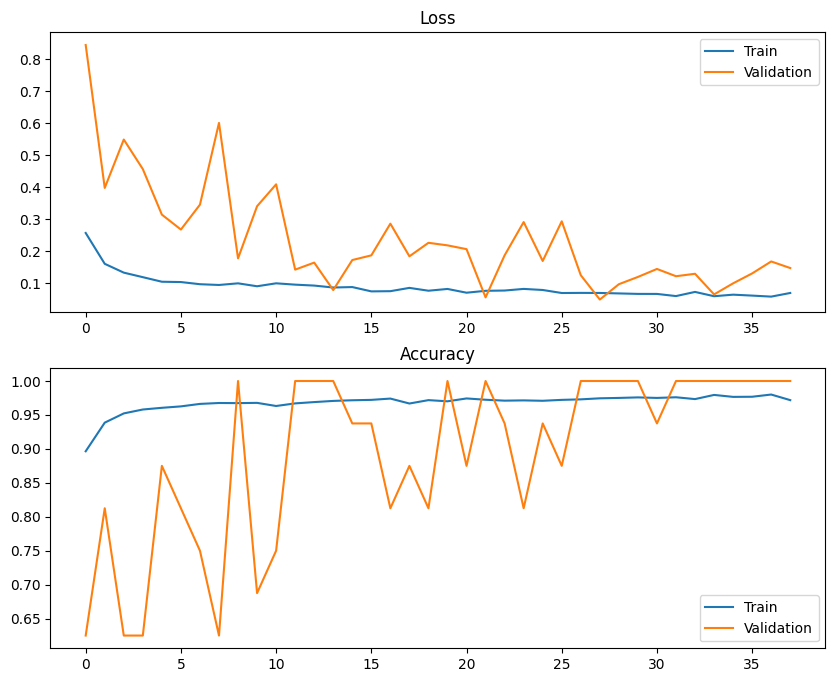

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history1.history["loss"], label="Train")
ax[0].plot(history1.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history1.history["accuracy"], label="Train")
ax[1].plot(history1.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [66]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Accuracy: 0.88782054 
Recall: 0.951282 
Precision: 0.87914693


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


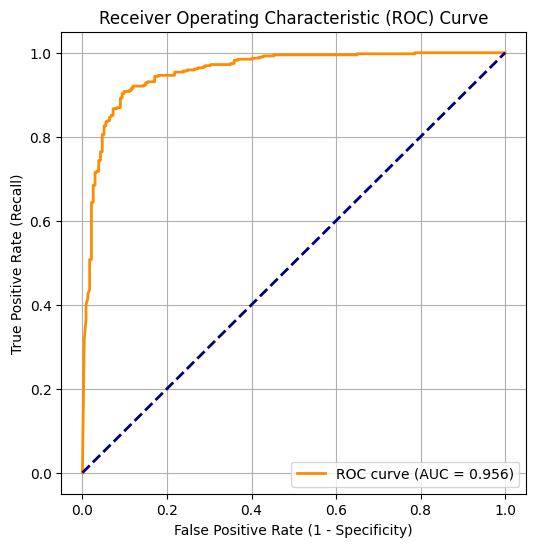

In [67]:
# 테스트셋 예측 확률 구하기
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X)
    y_true.extend(y)
    y_pred.extend(yhat)

# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# 그래프
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 기준선
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [68]:
#AUC/혼동행렬/클래스리포트 추가
y_true2, y_pred2 = [], []
for X, y in test.as_numpy_iterator():
    yhat = finetune_model.predict(X, verbose=0).ravel()
    y_true2.extend(y)      # 라벨
    y_pred2.extend(yhat)   # 확률

y_true2 = np.array(y_true2).ravel().astype(int)
y_pred2 = np.array(y_pred2).ravel()

auc = roc_auc_score(y_true2, y_pred2)
preds = (y_pred2 >= 0.5).astype(int)

cm = confusion_matrix(y_true2, preds)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)        # 민감도 (Sensitivity=Recall)
specificity = tn / (tn + fp)        # 특이도 (Specificity)

print("Confusion Matrix [[TN FP],[FN TP]]:\n", cm)
print(classification_report(y_true2, preds, target_names=["Normal","Pneumonia"]))
print(f"AUC: {auc:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

Confusion Matrix [[TN FP],[FN TP]]:
 [[183  51]
 [ 19 371]]
              precision    recall  f1-score   support

      Normal       0.91      0.78      0.84       234
   Pneumonia       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

AUC: 0.956
Sensitivity (Recall): 0.951
Specificity: 0.782


#4. 모델생성_2
상위 블록만 해제 후 파인 튜닝 (learning rate=> 더 작게)

In [69]:
# 2단계: 상위 블록(block5_conv*)만 훈련 가능하게 풀기
for layer in base.layers:
    if layer.name.startswith('conv5_'):
        layer.trainable = True
    else:
        layer.trainable = False

# 학습률을 더 작게
finetune_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# 다시 학습 (fine-tuning)
history2 = finetune_model.fit(
    train,
    epochs=30,
    validation_data=val,
    validation_steps=5,
    callbacks=[early_stopping]
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 651ms/step - accuracy: 0.9530 - loss: 0.1263 - val_accuracy: 0.8750 - val_loss: 0.2183
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 654ms/step - accuracy: 0.9761 - loss: 0.0748 - val_accuracy: 0.8750 - val_loss: 0.1815
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 711ms/step - accuracy: 0.9773 - loss: 0.0693 - val_accuracy: 0.8750 - val_loss: 0.2288
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 723ms/step - accuracy: 0.9835 - loss: 0.0521 - val_accuracy: 0.9375 - val_loss: 0.1353
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 715ms/step - accuracy: 0.9829 - loss: 0.0511 - val_accuracy: 0.8125 - val_loss: 0.3655
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.9844 - loss: 0.0413 - val_accuracy: 1.0000 - val_loss: 0.1046
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 719ms/step - accuracy: 0.9849 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 0.0612
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 711ms/step - accuracy: 0.9890 -

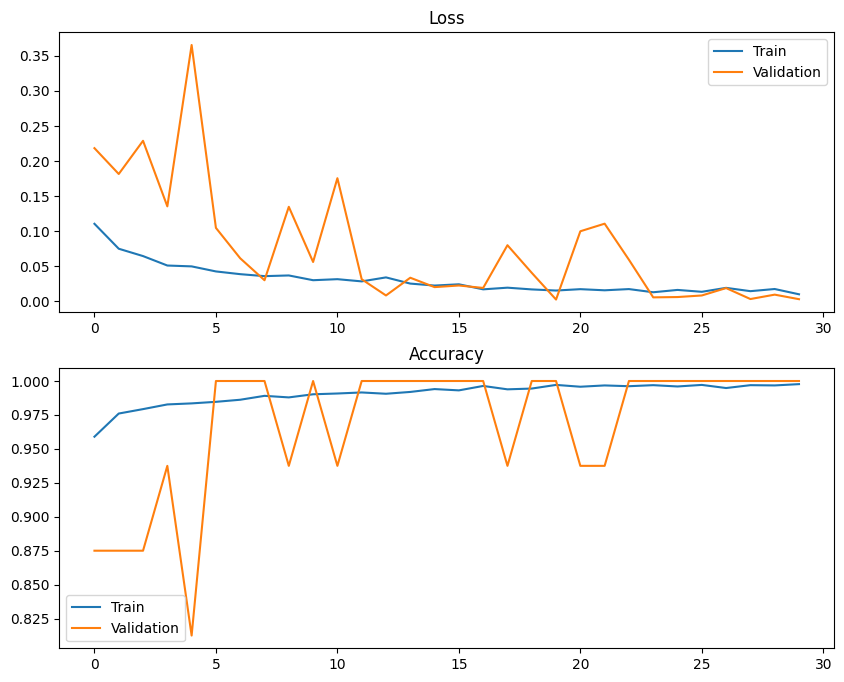

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history2.history["loss"], label="Train")
ax[0].plot(history2.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history2.history["accuracy"], label="Train")
ax[1].plot(history2.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [71]:
# 평가용 메트릭 초기화
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

# test 데이터셋으로 계산
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X, verbose=0)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Fine-tuned model (history2) metrics")
print(f"Accuracy : {bin_acc.result().numpy():.3f}")
print(f"Recall (Sensitivity): {recall.result().numpy():.3f}")
print(f"Precision: {precision.result().numpy():.3f}")


Fine-tuned model (history2) metrics
Accuracy : 0.904
Recall (Sensitivity): 0.959
Precision: 0.895


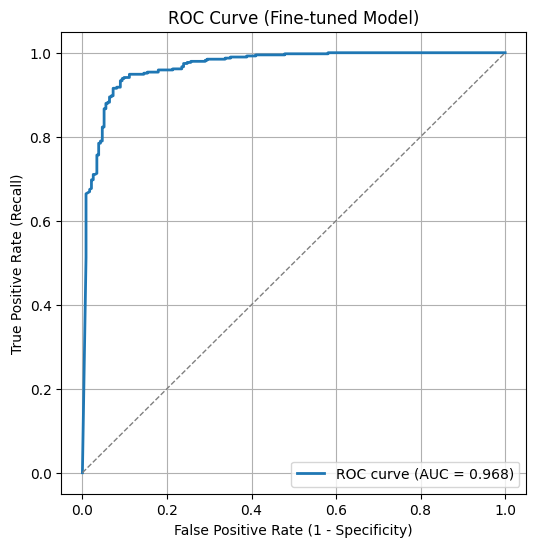

Confusion Matrix [[TN FP],[FN TP]]:
 [[190  44]
 [ 16 374]]
              precision    recall  f1-score   support

      Normal       0.92      0.81      0.86       234
   Pneumonia       0.89      0.96      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.89      0.89       624
weighted avg       0.91      0.90      0.90       624

AUC: 0.968
Sensitivity (Recall): 0.959
Specificity: 0.812


In [72]:
#예측 확률과 라벨 수집
y_true2, y_pred2 = [], []
for X, y in test.as_numpy_iterator():
    yhat = finetune_model.predict(X, verbose=0).ravel()
    y_true2.extend(y)
    y_pred2.extend(yhat)

y_true2 = np.array(y_true2).ravel().astype(int)
y_pred2 = np.array(y_pred2).ravel()

# ROC, AUC 계산
fpr, tpr, _ = roc_curve(y_true2, y_pred2)
auc = roc_auc_score(y_true2, y_pred2)

# ROC 곡선 그리기
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Fine-tuned Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 혼동행렬 및 지표 계산
preds = (y_pred2 >= 0.5).astype(int)
cm = confusion_matrix(y_true2, preds)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)  # True Negative Rate

# 5) 출력
print("Confusion Matrix [[TN FP],[FN TP]]:\n", cm)
print(classification_report(y_true2, preds, target_names=["Normal","Pneumonia"]))
print(f"AUC: {auc:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
